# Deep Learning &mdash; Assignment 3

Third assignment for the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2022_

-----

**Names:** Hauque, Federico Gabriel - Soler Sanz, Guillem

**Group:** 5

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Experiment with convolutional neural networks
2. Train a convolutional neural network on a speech dataset
3. Investigate the effect of dropout and batch normalization
4. Define and train a residual neural network

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book,
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

In [1]:
!pip install torch 
!pip install torchvision 
!pip install d2l==1.0.0a1.post0
!pip install python_speech_features 
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from d2l import torch as d2l
import torch
from torch import nn
from scipy.io import wavfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5886 sha256=284d167b811f924ec285f716d5ad8b418a3f6f1aa1d27846f57b8af59e2adc54
  Stored in directory: /root/.cache/pip/wheels/09/a1/04/08e2688d

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## 3.1 Convolution and receptive fields (9 points)

We will first define some helper functions to plot the receptive field of a network.

In [2]:
def show_image(img, title=None, new_figure=True):
    if new_figure:
        plt.figure(figsize=(5, 5))
    im = plt.imshow(img, interpolation='none', aspect='equal', cmap='gray')
    ax = plt.gca();

    # plot pixel numbers and grid lines
    ax.set_xticks(np.arange(0, img.shape[1], 1))
    ax.set_yticks(np.arange(0, img.shape[0], 1))
    ax.set_xticklabels(np.arange(0, img.shape[1], 1))
    ax.set_yticklabels(np.arange(0, img.shape[0], 1))
    ax.set_xticks(np.arange(-.5, img.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, img.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)

    # hide axis outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    if title is not None:
        plt.title(title)

# set all weights in the network to one,
# all biases to zero
def fill_weights_with_ones(network):
    for name, param in network.named_parameters():
        if 'weight' in name:
            param.data = torch.ones_like(param.data)
        elif 'bias' in name:
            param.data = torch.zeros_like(param.data)
    return network


def plot_receptive_field(network, input_size=(15, 15), binary=True):
    assert isinstance(network, torch.nn.Sequential), 'This only works with torch.nn.Sequential networks.'
    for layer in network:
        if not isinstance(layer, (torch.nn.Conv2d, torch.nn.AvgPool2d)):
            raise Exception('Sorry, this visualisation only works for Conv2d and AvgPool2d.')

    # initialize weights to ones, biases to zeros
    fill_weights_with_ones(network)

    # find the number of input and output channels
    input_channels = None
    output_channels = None
    for layer in network:
        if isinstance(layer, torch.nn.Conv2d):
            if input_channels is None:
                # first convolution layer
                input_channels = layer.in_channels
            output_channels = layer.out_channels
    if input_channels is None:
        input_channels = 1

    # first, we run the forward pass to compute the output shape give the input

    # PyTorch expects input shape [samples, channels, rows, columns]
    x = torch.zeros(1, input_channels, *input_size)
    x.requires_grad = True

    # forward pass: apply each layer in the network
    y = x
    y.retain_grad()
    ys = [y]
    for layer in network:
        y = layer(y)
        # keep track of the intermediate values so we can plot them later
        y.retain_grad()
        ys.append(y)

    # second, we run the backward pass to compute the receptive field

    # create gradient input: zeros everywhere, except for a single pixel
    y_grad = torch.zeros_like(y)
    # put a one somewhere in the middle of the output
    y_grad[0, 0, (y_grad.shape[2] - 1) // 2, (y_grad.shape[3] - 1) // 2] = 1

    # compute the gradients given this single one
    y.backward(y_grad)

    # plot the gradient at each layer
    plt.figure(figsize=(5 * len(ys), 5))
    for idx, y in enumerate(ys):
        plt.subplot(1, len(ys), idx + 1)
        # the gradient for this layer shows us the receptive field
        receptive_field = y.grad
        if binary:
            # plot the receptive field as a binary image
            receptive_field = receptive_field > 0
        # the last element of ys contains the output of the network
        if idx == len(ys) - 1:
            plot_title = 'output (%dx%d)' % (y.shape[2], y.shape[3])
        else:
            plot_title = 'layer %d input (%dx%d) with receptive field' % (idx, y.shape[2], y.shape[3])
        # plot the image with the receptive field (sample 0, channel 0)
        show_image(receptive_field[0, 0], new_figure=False, title=plot_title)
        if not binary:
            plt.colorbar(fraction=0.047 * receptive_field.shape[0] / receptive_field.shape[1])

Using these functions, we can define a network and plot its receptive field.

**(a) Run the code to define a network with one 3×3 convolution layer and plot the images.**

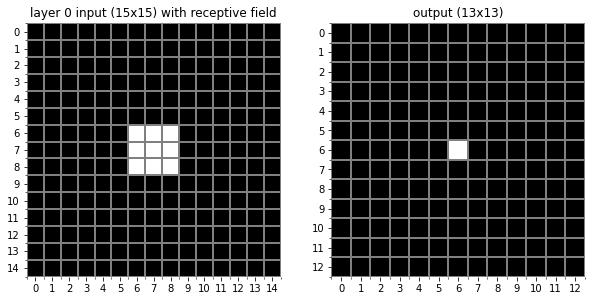

In [6]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3)),
)
plot_receptive_field(net, input_size=(15, 15))

Read these images as follows:
* On the left, you see the input size of the network (here: 15 x 15 pixels) and the receptive field for one pixel in the output.
* On the right, you see the output size of the network (here: 13 x 13 pixels).

To visualize the receptive field of this network, we used the following procedure:
* We selected one pixel of the output (shown as the white pixel in the center in the image on the right).
* We computed the gradient for this pixel and plotted the gradient with respect to the input (the image on the left).
* This shows you the receptive field of the network: the output for the pixel we selected depends on these 9 pixels in the input.

**(b) Use this method to plot the receptive field of a convolution layer with a kernel size of 5×5.<span style="float:right"> (1 point)</span>**

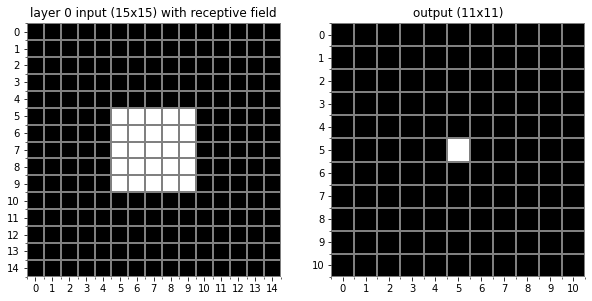

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))

If you look at the result, you will see that two things have changed: the receptive field and the output size.

**(c) How do the receptive field and the output size depend on the kernel size?<span style="float:right"> (1 points)</span>**

When the kernel is bigger, each convolution takes a broader space and therefore generates a smaller output. The receptive field is equally sized to the kernel, so grows together with it.

### Counting the number of parameters

In the previous question, you saw how the receptive fields of a 3x3 convolution differs from a 5x5 kernel convolution. But this is not the only difference: there is also a difference in the number of parameters in the network.

We can count the number of parameters in the network by computing the number of elements (e.g., the weights and biases in a convolution kernel) in the parameter list of the PyTorch network.

We'll define a small helper function to do this:

In [7]:
def print_parameter_count(network):
    # sum the number of elements in each parameter of the network
    count = sum([param.data.numel() for param in network.parameters()])
    print('%d parameters' % count)

**(d) Use the function to count the number of parameters for a 3x3 convolution.**

10 parameters


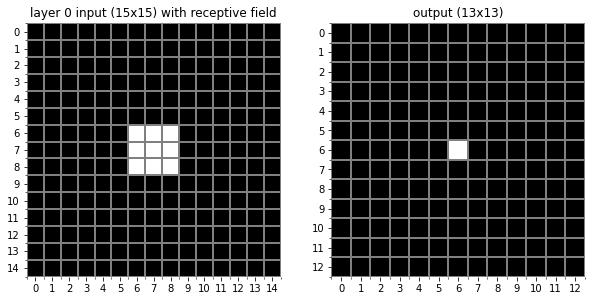

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(e) Do the same to count the number of parameters for a 5x5 convolution.<span style="float:right"> (1 point)</span>**

26 parameters


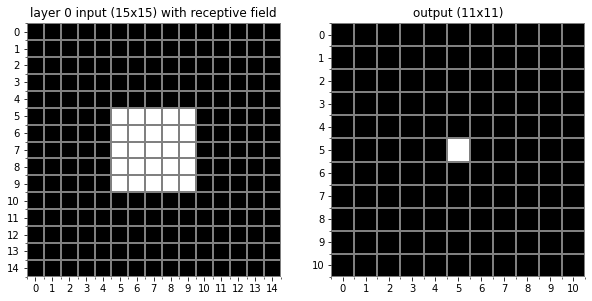

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(f) Explain the results by showing how to _compute_ the number of parameters for the 3x3 and 5x5 convolutions.<span style="float:right"> (1 point)</span>**

The number of parameters is always equal to the size of the kernel (3x3 = 9 or 5x5 = 25) + an additional parameter for the bias term.

For these computations we used convolution layers with one input and one output channel.

We can also compute the results for a layer with a different number of channels.

**(g) Define a network with a 5x5 convolution, 2 input channels and 3 output channels. Print the number of parameters.**

153 parameters


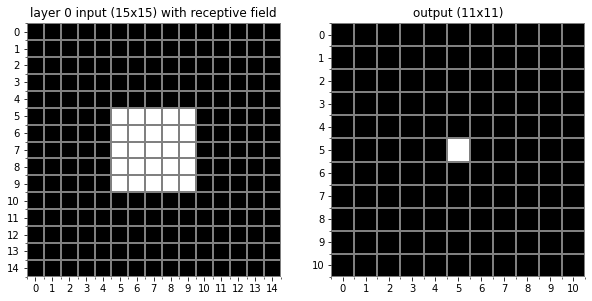

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(2, 3, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(h) Show how to compute the number of parameters for this case.<span style="float:right"> (1 point)</span>**

In this case, the kernel size is multiplied by the number of input and output layers and each output layer has its own bias term. 
Hence 9 * 3 * 2 + 3 = 57

### Preserving the size of the input image

The PyTorch documentation for [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) describes the parameters that you can use to define a convolutional layer. We will explore some of those parameters in the next questions.

In the previous plot, you may have noticed that the output (13x13 pixels) was slightly smaller than the input (15x15 pixels).

**(i) Define a network with a single 3x3 convolutional layer that produces an output that has the same size as the input.<span style="float:right"> (1 point)</span>**

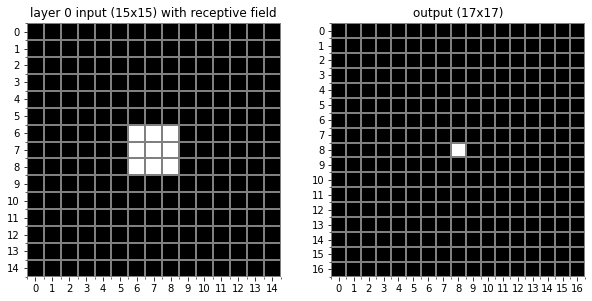

In [12]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=2),
)
plot_receptive_field(net, input_size=(15, 15))

**(j) Define a network with a single 5x5 convolutional layer that preserves the input size.<span style="float:right"> (1 point)</span>**

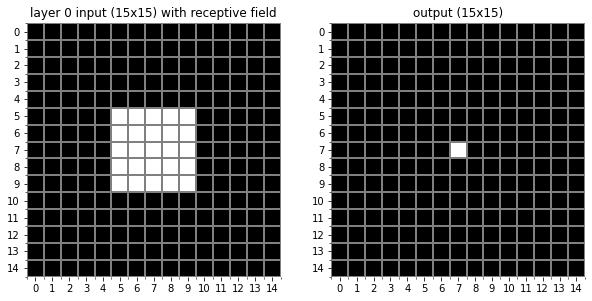

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5), padding=2),
)
plot_receptive_field(net, input_size=(15, 15))

Play around with some other values to see how this parameter behaves.

### Multiple layers

As you have just seen, one way to increase the size of the receptive field is to use a larger convolution kernel. But another way is to use more than one convolution layer.

**(k) Define a network with two 3x3 convolutions, preserving the image size. Show the receptive field and the number of parameters.<span style="float:right"> (1 point)</span>**

For this visualisation, do not use any activation functions.

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
20 parameters


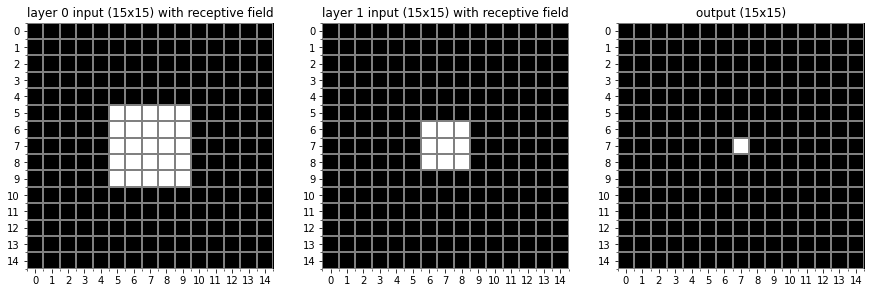

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
)
print(net)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

Since we now have two layers, the visualization shows an extra image. From right to left, we have:
* Right: the output size and a single active pixel.
* Middle: the receptive field for the single output pixel between the first and second convolution.
* Left: the receptive field for the single output pixel in the input image.

We have now tried two ways to increase the receptive field: increasing the kernel size, and using multiple layers.

**(l) Compare the number of parameters required by the two options. Which one is more parameter-efficient?<span style="float:right"> (1 point)</span>**

The increase in the kernel size required almost three times the number of parameters of two convolutional neuarl networks. The second alternative is definitely the most parameter efficient.

## 3.2 Variations on convolution (8 points)

### Pooling

We can also increase the size of the receptive field by using a pooling layer.

**(a) Construct a network with a 3x3 convolution (preserving the input size) followed by a 2x2 average pooling. Plot the receptive field and print the number of parameters.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
)
10 parameters


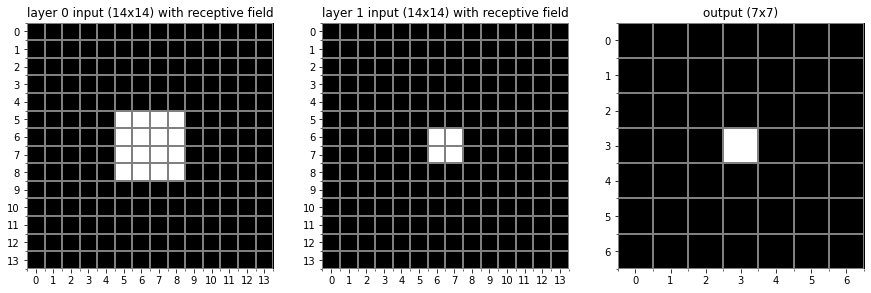

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
    torch.nn.AvgPool2d(kernel_size=(2,2)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(b) Explain the number of parameters in this convolution + pooling network.<span style="float:right"> (1 point)</span>**

The number of parameters is given by the kernel size + bias only. It is the same as the first example.

### Dilation

A third option to increase the receptive field is _dilation_.

**(c) Define a network with 3x3 convolution with dilation that preserves the input size.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
)
10 parameters


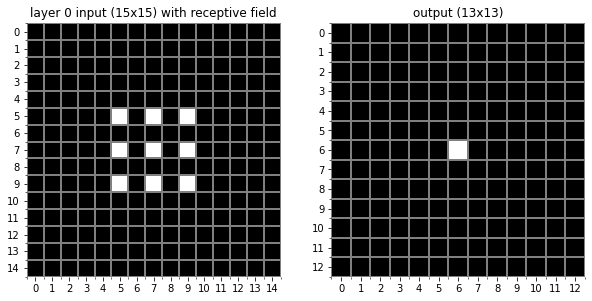

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1, dilation=2),
)
print(net)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(d) Explain how dilation affects the receptive field.<span style="float:right"> (1 point)</span>**

Dilation separates the positions from which the receptive field is placed. Instead of being a set of adjacent values, they become more and more distant as dilation increases. The dilation value is the number of positions in between.

### Using strides

By default, convolution layers use a stride of 1.

**(e) Change the network to use a stride of 2 and plot the result.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
10 parameters


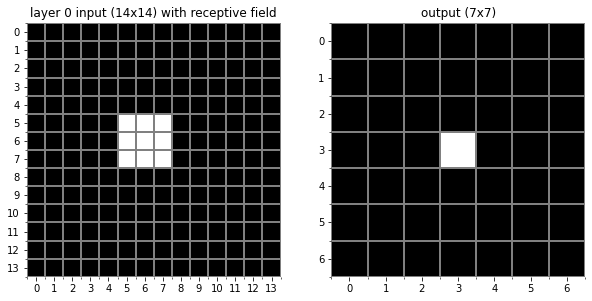

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1), stride=(2,2)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(f) Explain the new output size and compare the result with that of pooling.<span style="float:right"> (1 point)</span>**

The output is the same size and result. Nonetheless, the stride achieved this by increasing teh step when moving over the pixels, while the pooling achieved it by calculating the average of all the ellements in the receptive field. (which in this case is the same because all the numbers in the matrix are 1.)

**(g) Explain how the stride affects the receptive field of this single convolution layer.<span style="float:right"> (1 point)</span>**

The stride increases the step by which the kernel moves over the pixels. Instead of doing it one by one, a stride of two skips one pixel before computing the next one. 

**(h) Explain the number of parameters for this network.<span style="float:right"> (1 point)</span>**

Since there is the same 3x3 layer with 9 parameters + the bias (10 in total), there are no additional parameters required for just implementing a stride.

## 3.3 Combining layers (8 points)

As you have seen, there are multiple ways to increase the receptive field. You can make interesting combinations by stacking multiple layers.

Let's try a few ways to make networks with a large receptive field. For the following questions:

* Create a network that has a 9x9 receptive field.
* Use 3 input channels and 3 output channels in every layer.
* In convolution layers, try to preserve the input size as much as possible.

**(a) Make a network with a single convolution layer to obtain a 9x9 receptive field. Preserve the input size.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
)
732 parameters


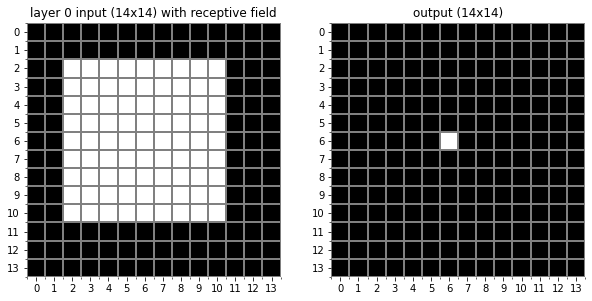

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=(9, 9), padding=(4, 4)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

Many popular network architectures use a sequence of 3x3 convolutions.

**(b) Use only 3x3 convolutions to get the 9x9 receptive field.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
336 parameters


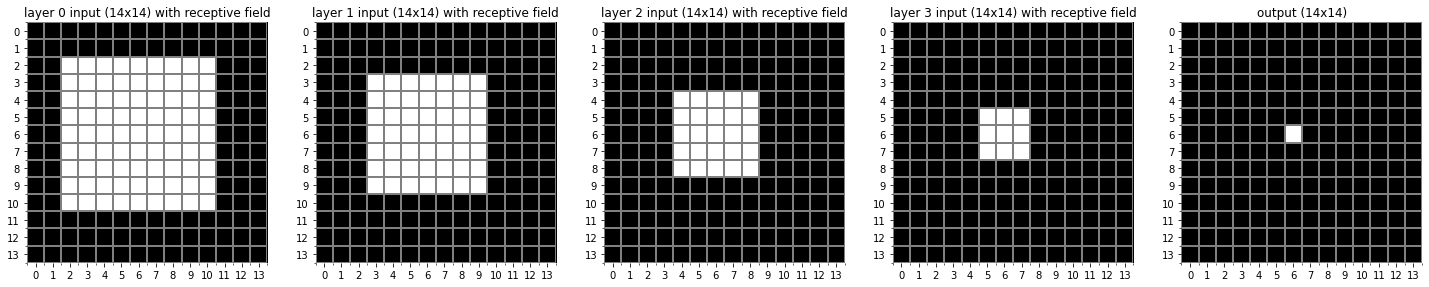

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(1, 1)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(c) Use 2x2 or 3x3 convolutions and 2x2 average pooling.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (6): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (7): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
)
273 parameters


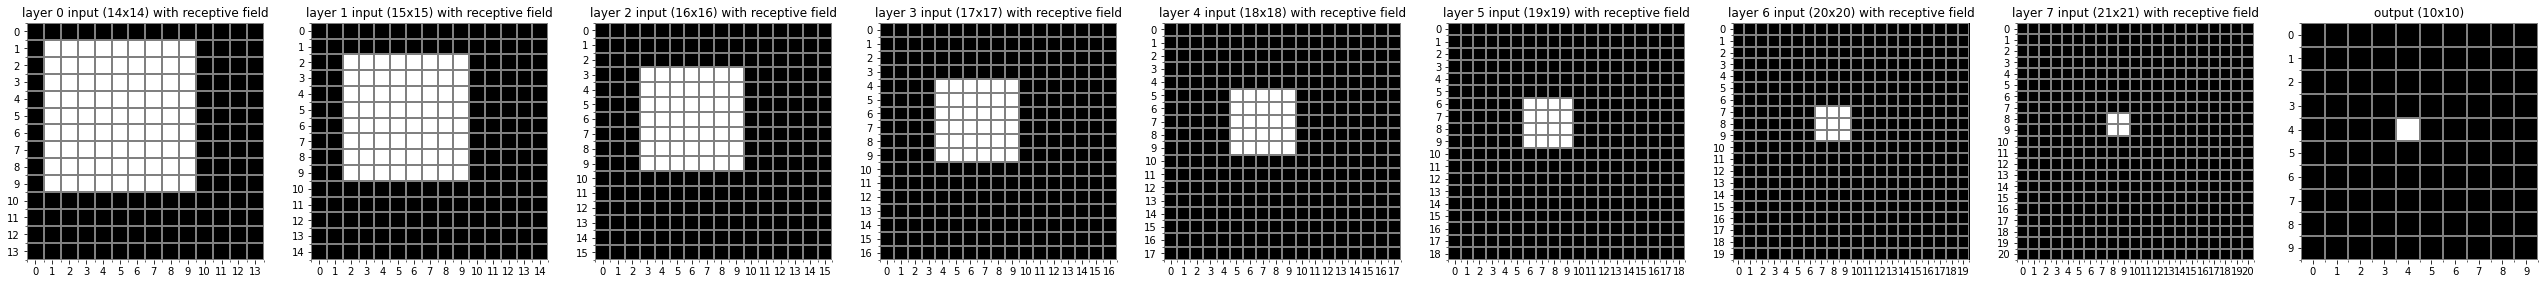

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.AvgPool2d(kernel_size=(2,2)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(d) Copy the previous convolution + pooling network and replace the pooling layer with a strided convolution layer.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (6): Conv2d(3, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (7): Conv2d(3, 3, kernel_size=(2, 2), stride=(2, 2))
)
312 parameters


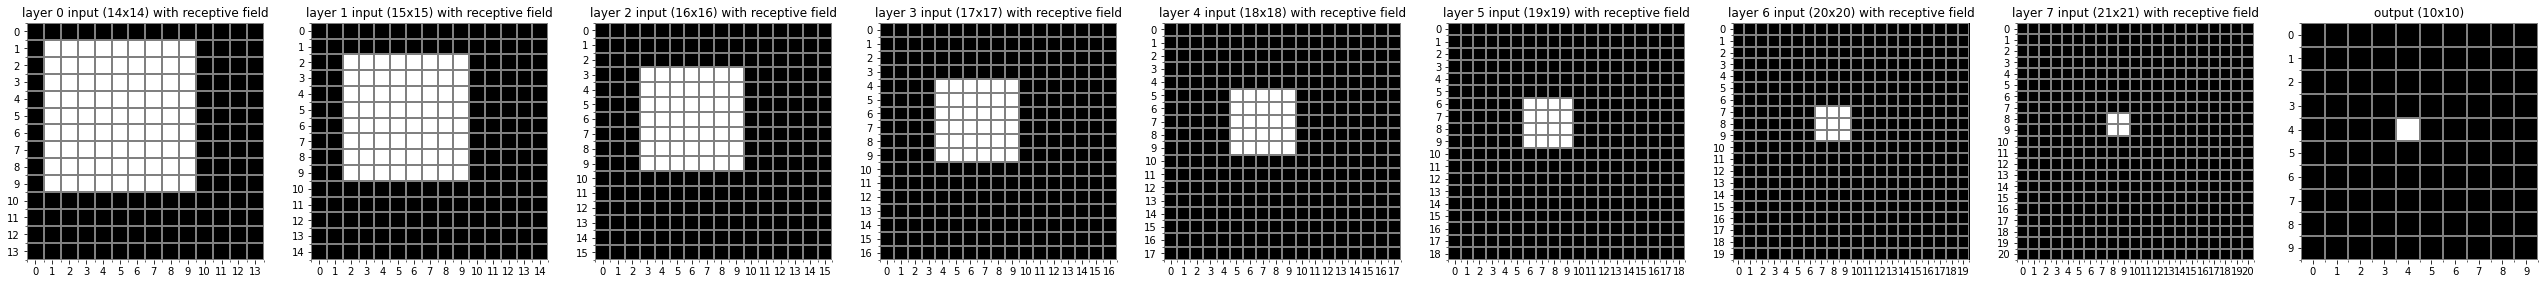

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(2, 2), stride=(2,2)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(e) Construct a network with exactly two 3x3 convolutions. Use dilation to get a receptive field of 9x9 pixels.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
)
168 parameters


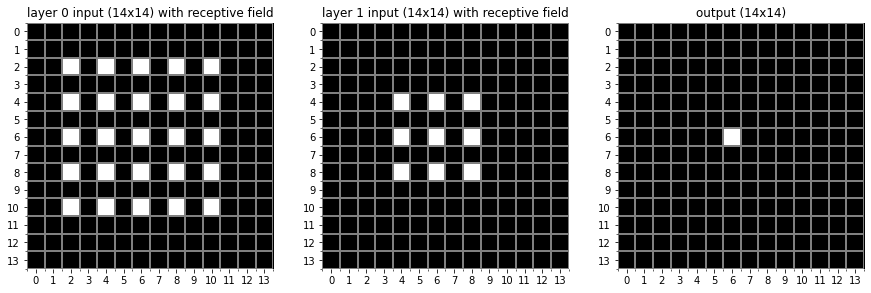

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(2, 2), dilation=2),
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(2, 2), dilation=2),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(f) For each of the methods, list the number of layers, the number of parameters, and the size of the output:**

| Method                    | Layers | Parameters | Output size |
|---------------------------|--------|------------|-------------|
| One 9x9 convolution       |    1   |     732    |    14x14    | 
| Many 3x3 convolutions     |    4   |     336    |    14x14    |
| With pooling              |    7   |     273    |    10x10    |
| With strided convolution  |    7   |     312    |    10x10    |
| With dilation             |    2   |     168    |    14x14    |

**(g) Compare the methods in terms of the number of parameters.<span style="float:right"> (1 point)</span>**

The biggest kernel requires the most number of parameters, while the dilation, pooling and strided convolution have the lowest values. 

**(h) Compare the methods in terms of the output size. How much downsampling do they do?<span style="float:right"> (1 point)</span>**

Each 3x3 layer reduces the dimension by one, while an avg pooling layer reduces it to half. We have applied padding in many layers, so there has not been too much downsampling, but if we did not, it would have been quite significant.

**(i) Compare the methods in terms of network depth. How does this affect the power and model complexity of the networks?<span style="float:right"> (1 point)</span>**

The networks with more layers tend to have less parameters, but can increase the downsampling significantly if no proper padding is added.

## 3.4 Padding in very deep networks (2 points)

Without padding, the output of a convolution is smaller than the input. This limits the depth of your network.

**(a) How often can you apply a 3x3 convolution to a 15x15 input image?**

In [ ]:
# find the maximum number of layers
number_of_times = 25

# create a 15x15 input
x = torch.zeros(1, 1, 15, 15)
print('input size: %dx%d' % (x.shape[2], x.shape[3]))

# create a 3x3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3))

for n in range(number_of_times):
    # apply another convolution
    #x = conv(x)
    print('layer %d, output size: %dx%d' % (n + 1, x.shape[2], x.shape[3]))

input size: 15x15
layer 1, output size: 15x15
layer 2, output size: 15x15
layer 3, output size: 15x15
layer 4, output size: 15x15
layer 5, output size: 15x15
layer 6, output size: 15x15
layer 7, output size: 15x15
layer 8, output size: 15x15
layer 9, output size: 15x15
layer 10, output size: 15x15
layer 11, output size: 15x15
layer 12, output size: 15x15
layer 13, output size: 15x15
layer 14, output size: 15x15
layer 15, output size: 15x15
layer 16, output size: 15x15
layer 17, output size: 15x15
layer 18, output size: 15x15
layer 19, output size: 15x15
layer 20, output size: 15x15
layer 21, output size: 15x15
layer 22, output size: 15x15
layer 23, output size: 15x15
layer 24, output size: 15x15
layer 25, output size: 15x15


Earlier in this assignment, you have used padding to address this problem. This seems ideal.

**(b) Copy the previous code, add some padding, and show that we can now have an infinite number of layers.**

(We are computer scientists and not mathematicians, so for the purpose of this question we'll consider 'infinite' to be equal to 25.)

In [ ]:
# find the maximum number of layers
number_of_times = 25

# create a 15x15 input
x = torch.zeros(1, 1, 15, 15)
print('input size: %dx%d' % (x.shape[2], x.shape[3]))

# create a 3x3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1,1))

for n in range(number_of_times):
    # apply another convolution
    x = conv(x)
    print('layer %d, output size: %dx%d' % (n + 1, x.shape[2], x.shape[3]))

input size: 15x15
layer 1, output size: 15x15
layer 2, output size: 15x15
layer 3, output size: 15x15
layer 4, output size: 15x15
layer 5, output size: 15x15
layer 6, output size: 15x15
layer 7, output size: 15x15
layer 8, output size: 15x15
layer 9, output size: 15x15
layer 10, output size: 15x15
layer 11, output size: 15x15
layer 12, output size: 15x15
layer 13, output size: 15x15
layer 14, output size: 15x15
layer 15, output size: 15x15
layer 16, output size: 15x15
layer 17, output size: 15x15
layer 18, output size: 15x15
layer 19, output size: 15x15
layer 20, output size: 15x15
layer 21, output size: 15x15
layer 22, output size: 15x15
layer 23, output size: 15x15
layer 24, output size: 15x15
layer 25, output size: 15x15


**(c) Does it really work like this? Have a look at the following experiment.**

* We simulate a convolution network with 25 convolution layers, with 3x3 kernels and the right amount of padding.
* We set the weights to 1/9 (so that the sum of the 3x3 kernel is equal to 1) and set the bias to zero.
* We give this network a 15x15-pixel input filled with ones.
* We plot the output of layers 5, 10, 15, 20, and 25.

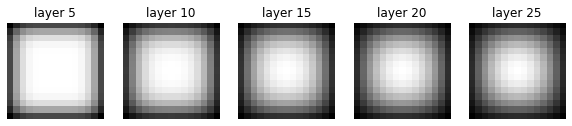

In [ ]:
# create a 15x15 input filled with ones
x = torch.ones(1, 1, 15, 15)

# create a 3x3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1))

# set weights to 1/9 (= sum to one), bias to zero
conv.weight.data = torch.ones_like(conv.weight.data) / 9
conv.bias.data = torch.zeros_like(conv.bias.data)

plt.figure(figsize=(10, 2))
for n in range(1, 26):
    # apply another convolution
    x = conv(x)
    # print('layer %d, output size: %dx%d' % (n + 1, x.shape[2], x.shape[3]))
    if n % 5 == 0:
        plt.subplot(1, 5, n // 5)
        plt.imshow(x[0, 0].detach().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('layer %d' % n)

**(d) Explain the pattern that we see in the output of the final layers. How does this happen, and what does this mean for our very deep networks?<span style="float:right"> (2 points)</span>**

It is visible that the padding is changing the data from the edges progressively. We begin with an input full of ones, but after many convolutions, the zeros present in tghe padding possitions start to affect their adjacent input pixels. This is progressively moving from the edges to the more inner parts of the image in the deepest layers.

## 3.5 Spoken digits dataset (4 points)

Time for some practical experiments. The d2l book uses a dataset of images as a running example (FashionMNIST). In this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**(a) Use `git clone` to download the dataset.**

In [ ]:
! git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4240, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 4240 (delta 14), reused 8 (delta 8), pack-reused 4212
Receiving objects: 100% (4240/4240), 30.38 MiB | 26.05 MiB/s, done.
Resolving deltas: 100% (118/118), done.


Below is a function to load the data. We pad/truncate each sample to the same length.
The raw audio is usually stored in 16 bit integers, with a range -32768 to 32767, where 0 represents no signal. Before using the data, it should be normalized. A common approach is to make sure that the data is between 0 and 1, between -1 and 1, or zero-mean unit-variance.  Not all of these work well on this data, so later on, if your
network doesn't seem to learn anything: try a different method to see if that works better.

**(b) Update the below code to normalize the data to a reasonable range.<span style="float:right"> (1 point)</span>**

In [ ]:
samplerate = 8000
def normalize(v):
    norm = np.linalg.norm(v)
    
    mean = np.matrix.mean(np.matrix(v))
    std = np.matrix.std(np.matrix(v))
    if std == 0: 
        return v
    return (v-mean)/std

def load_waveform(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform,(0,size))[0:size]
  
    waveform_norm = normalize(waveform)
    return waveform_norm

The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**(c) Load the data into a variable `data`.**

In [ ]:
from google.colab import drive

class SpokenDigits(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.x = self.x.unsqueeze(1) # One channel
        self.y = torch.from_numpy(np.array(digits_y))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]



data =SpokenDigits('/content/free-spoken-digit-dataset/recordings/')



**(d) Describe the dataset: how many samples are there, how many feature dimensions are there? How many classes are there?<span style="float:right"> (1 point)</span>**

In [ ]:
lista = []
print(sum)
print(f' The dataset has {data.__len__()} samples')

print(f' The dataset has {data.__len__()}*{len(data.x[0][0])} dimensions') 
for value in data.y:
  if value not in lista:
    lista.append(value)

print(f' The dataset has {len(lista)} classes')


<built-in function sum>
 The dataset has 3000 samples
 The dataset has 3000*6000 dimensions
 The dataset has 10 classes


Here is code to play samples from the dataset to give you an idea what it "looks" like.

Note: If this step doesn't work in your notebook, then you can ignore it.

In [ ]:
from IPython.display import Audio
def play(sample):
    print(f'Label: {sample[1]}')
    return Audio(sample[0][0].numpy(), rate=samplerate)
play(data[0])

Label: 7


Before continuing, we split the dataset into a training and a test set.

In [ ]:
train_prop = 2/3
train_count = int(len(data) * train_prop)
train, test = torch.utils.data.random_split(data, [train_count, len(data) - train_count])

The code above uses 2/3 of the data for training.

**(e) Discuss an advantage and disadvantage of using more of the data for training.<span style="float:right"> (2 points)</span>**

The advantages of use more data for training is that your model has more examples to learn how to classify correctly, if you don't use enough data to train the model you may fall into underfitting . Nevertheless , if you use to much data to train the model you may fall into overfitting when you test your model. There isn't a perfect size to the train and test data but offtently is used 70% to train and 30% to test. However in the vast majority of the cases it depends on the data that we have.

Finally, we split the data into batches:

In [ ]:
data_params = {'batch_size': 32}
train_iter = torch.utils.data.DataLoader(train, **data_params)
test_iter  = torch.utils.data.DataLoader(test,  **data_params)

## 3.6 One-dimensional convolutional neural network (8 points)

We will now define a network architecture. We will use a combination of convolutional layers and pooling.
Note that we use 1d convolution and pooling here, instead of the 2d operations used for images.

**(a) Complete the network architecture, look at the d2l book [chapter 7](http://d2l.ai/chapter_convolutional-neural-networks/index.html) and [chapter 8](http://d2l.ai/chapter_convolutional-modern/index.html) for examples.<span style="float:right"> (2 points)</span>**

In [ ]:
net = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
   
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

**(b) The first fully connected layer has input dimension 11872, where does that number come from?<span style="float:right"> (1 point)</span>**

Hint: think about how (valid) convolutional layers and pooling layers with stride affect the size of the data.


The number 11872 makes reference to the input features coming from the previous layer, in which all the channels are flattened to a single input, whose size is 11872.



**(c) How many parameters are there in the model? I.e. the total number of weights and biases.<span style="float:right"> (1 point)</span>**

In [ ]:

def count_params(model):
    """Count the number of parameters in a module."""
    sum = 0
    for p in model.parameters():
      sum += int(p.nelement())
    
    return sum

count_params(net)

1532090

**(d) Suppose that instead of using convolutions, we had used only fully connected layers, while keeping the number of features on each hidden layer the same. How many parameters would be needed in that case approximately?<span style="float:right"> (1 point)</span>**

To calculate the number of parameters in the convolutional layers we use an expression like that :

(( shape of width of the filter * shape of height of the filter * number of filters in the previous layer+1)*number of filters) 

Instead, in order to calculate the parameters of a fully conected layer we use this expression: 
((Current layer neurons c * previous layer neurons p) + 1*c ).

The FashionMNIST dataset used in the book has 60000 training examples. How large is our training set? How would the difference affect the number of epochs that we need? Compare to [chapter 7.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html) and [chapter 8.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html) of the book.

**(e) How many epochs do you think are needed?<span style="float:right"> (1 point)</span>**

In [ ]:
lr, num_epochs = 0.05, 100 # With only 40 epochs the network converges

We will use the code from (a previous edition of) the d2l book to train the network.
In particular, the `train` function, defined in [chapter 7.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html#training). This function is reproduced below:

In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr, device = d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

**(f) Now train the network.**

loss 0.000, train acc 1.000, test acc 0.730
543.3 examples/sec on cpu


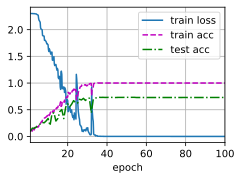

In [ ]:
train(net, train_iter, test_iter, num_epochs, lr)

**(g) Did the training converge?<span style="float:right"> (2 point)</span>**

**If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.**

Hint: This is a non-trivial problem, so your network might take some time to
learn. Don't give up too quickly, it might take 50-100 epochs before you
see any significant changes in the loss curves.

TODO: Document the changes that you made and their effect in the table below.

| Experiment                | epochs | lr     | train accuracy | test accuracy | converged? |
|---------------------------|--------|--------|----------------|---------------|------------|
| experiment 1              | 100    | 0.0001 |    1           |    0.37           |   yes         |------------|
| experiment 2             | 100   | 0.001   |       1     |     0.503          |      yes      |------------|
| experiment 3             | 100  |  0.05  |      1        |  0.73             |      yes      |------------|
| experiment 4              | 100  | 0.0015   |    1       | 0.60              |     yes       |------------|
| experiment 5              | 100   | 0.02   |      1          |  0.55             |      yes      |


With the parameters that we used the training converges over the 30 epochs. We have seen that the learning rate has a strong influence in this result because like we can see in the table with other learning rates the model was not able to converge.


## 3.7 Questions and evaluation (6 points)

**(a) Does the network look like it is overfitting or underfitting?<span style="float:right"> (1 point)</span>**

The network looks like it is overfitting, as we can see in the graph the train accuracy and the loss are perfect. Nevertheless, we observe that the test accuracy is relatively low, originating a significant generalitzation gap.

**(b) Is what we have here a good classifier? Could it be used in a realistic application?<span style="float:right"> (1 point)</span>**

The classifier that we obtained is not good enough to be used in a realistic apllication, the network is overfitting so the results could be improved

**(c) Do you think there is enough training data compared to the dimensions of the data and the number of parameters?<span style="float:right"> (1 point)</span>**

I think that with more training data we could improve the obtained results since the number of parameters in this network is prety high and the availiability of more information could help in reduccing the overfitting.

**(d) How could the classifier be improved?<span style="float:right"> (1 point)</span>**

The classifier could be improved with either more train data or implementing dropout, since these two are very likely to help in preventing the model's overfitting. The learning rate could be slightly adjusted to achieve convergence faster. Adding batch noramlization could also be very useful to achieve more stability while converging.

**(e) The free spoken digits datasets has recordings from several different speakers. Is the test set accuracy a good measure of how well the trained network would perform for recognizing the voice of a new speaker? And if not, how could that be tested instead?<span style="float:right"> (2 points)</span>**

Since the test set includes random seaparated data from different speakers, there is no guarantee that any of the speakers of the test set was noty used to train the model. Therefore, we could ensure that at least one of the voices is completely isolated in the test set, so that the model does not know it even exists during the training, and the test accuracy for these specific group of voices represents better this situation in which a new unknown voice is analyzed.
We could have two test accuracies, one for known voices, and another one for unknown one. The former shows how well the dataset is being fitted, while the second one shows how well generalized is for new speakers. 

## 3.8 Variations (8 points)

One way in which the training might be improved is with dropout or with batch normalization.

**(a) Make a copy of the network architecture below, and add dropout.<span style="float:right"> (1 point)</span>**

Hint: see [chapter 8.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html#architecture) for an example that uses dropout.

loss 0.142, train acc 0.959, test acc 0.776
503.6 examples/sec on cpu


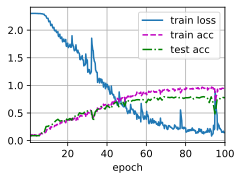

In [ ]:
net_dropout = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    

     
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(128, 64), nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(64, 10))

train(net_dropout, train_iter, test_iter, num_epochs, lr)

**(b) How does dropout change the results? Does this match what you saw on the simple network last week?<span style="float:right"> (1 point)</span>**

This makes the model more robust and the larger sample size effectively reduces overfitting. It is similar to the outcomes that we've seen earlier when appliying data augmentation techniques last week. 

**(c) Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.<span style="float:right"> (1 point)</span>**

Hint: see [chapter 8.5](http://d2l.ai/chapter_convolutional-modern/batch-norm.html#concise-implementation) for an example.

loss 0.001, train acc 1.000, test acc 0.849
456.1 examples/sec on cpu


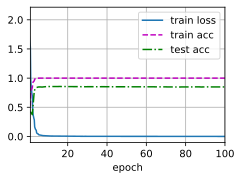

In [ ]:
net_batchnorm = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    
  
     
    nn.Conv1d(4, 8, kernel_size=5),nn.LazyBatchNorm1d(), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5),nn.LazyBatchNorm1d(), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5),nn.LazyBatchNorm1d(), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(11872, 128),nn.LazyBatchNorm1d(), nn.ReLU(),
    nn.Linear(128, 64), nn.LazyBatchNorm1d(),nn.ReLU(),
    nn.Linear(64, 10))

train(net_batchnorm, train_iter, test_iter, num_epochs, lr)

**(d) How does batch normalization change the results? Does this match what you saw on the simple network last week?<span style="float:right"> (1 point)</span>**

The batch normalization mades the network to converge earlier, with only 5 epochs. Also, the curves look much more stable and oscillations are almost non-existent. The behaviour of the last week network was the same, when we add batch normalization the network converges faster.

### Residual network

We can also try to use a residual network. The book has code for a 2d resnet in [Chapter 8.6](http://d2l.ai/chapter_convolutional-modern/resnet.html).

**(e) Copy the `Residual` module here, and addapt it for 1d convolutions.<span style="float:right"> (2 point)</span>**

Use residual blocks each containing two convolutional layers.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  
    """The Residual block of ResNet."""
    def __init__(self, out_cannels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv1d(out_cannels, kernel_size = 5,
                                   stride=strides,padding=1)
                                  
        self.conv2 = nn.LazyConv1d(out_cannels, kernel_size = 5,padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv1d(out_cannels, kernel_size = 5,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm1d()
        self.bn2 = nn.LazyBatchNorm1d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


**(f) Make a copy of the network architecture, and replace the convolutions with residual blocks.<span style="float:right"> (1 point)</span>**

loss 0.000, train acc 1.000, test acc 0.959
215.6 examples/sec on cpu


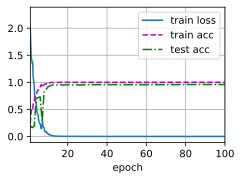

In [ ]:
resnet = torch.nn.Sequential(
    Residual(4, use_1x1conv=True), 
    nn.AvgPool1d(kernel_size=2, stride=2),
    
  
     
    Residual(8, use_1x1conv=True), 
    nn.AvgPool1d(kernel_size=2, stride=2),
    Residual(16, use_1x1conv=True),
    nn.AvgPool1d(kernel_size=2, stride=2),
    Residual(32, use_1x1conv=True),
    nn.AvgPool1d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

train(resnet, train_iter, test_iter, num_epochs, lr)

**(g) How do residual connections change the results?<span style="float:right"> (1 point)</span>**

The residual connections made the network to converge really early. It seems that the network fall into overfitting because the train loss is 0 and the train accuracy is 1, but as we can see we achieve a great performance in the test accuracy


## 3.9 Feature extraction (5 points)

Given enough training data a deep neural network can learn to extract features from raw data like audio and images. However, in some cases it is still necessary to do manual feature extraction, in particular when working with smaller datasets like this one. For speech recognition, a popular class of features are [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

Here is code to extract these features. You will need to install the `python_speech_features` first.

In [ ]:
from python_speech_features import mfcc

def load_waveform_mfcc(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform,(0,size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**(a) Implement a variation of the dataset that uses these features.<span style="float:right"> (2 points)</span>**

In [ ]:
class SpokenDigitsMFCC(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform_mfcc(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        #self.x = self.x.unsqueeze(1) # One channel
        self.y = torch.from_numpy(np.array(digits_y))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    pass

data_mfcc = SpokenDigitsMFCC('/content/free-spoken-digit-dataset/recordings/')
train_count_mfcc = int(len(data_mfcc) * train_prop)
train_mfcc, test_mfcc = torch.utils.data.random_split(data_mfcc, [train_count_mfcc, len(data_mfcc)-train_count_mfcc])
train_iter_mfcc = torch.utils.data.DataLoader(train_mfcc, **data_params)
test_iter_mfcc  = torch.utils.data.DataLoader(test_mfcc,  **data_params)

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**(b) Inspect the shape of the data, and define a new network architecture that accepts data with this shape.<span style="float:right"> (1 point)</span>**

In [ ]:
net_mfcc = torch.nn.Sequential(
    nn.Conv1d(13, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(64, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(256, 1024, kernel_size=3, padding=1), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(1024, 2968, kernel_size=3, padding=1), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

**(c) Train the network with the mfcc features.<span style="float:right"> (1 point)</span>**

loss 0.001, train acc 1.000, test acc 0.976
42.5 examples/sec on cpu


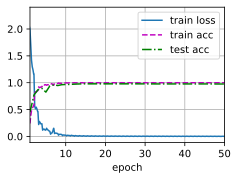

In [ ]:
print(train_iter_mfcc.dataset.dataset.x.shape, train_iter_mfcc.dataset.dataset.y.shape)
train(net_mfcc, train_iter_mfcc, test_iter_mfcc, 50, lr)

loss 0.031, train acc 0.990, test acc 0.943
41.0 examples/sec on cpu


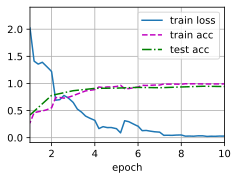

In [ ]:
print(train_iter_mfcc.dataset.dataset.x.shape, train_iter_mfcc.dataset.dataset.y.shape)
train(net_mfcc, train_iter_mfcc, test_iter_mfcc, num_epochs, lr)

**(d) What would be needed to get a fully neural network approach to work as well as MFCC features?<span style="float:right"> (1 point)</span>**

The residual blocks we tried earlier were capable of achieving a reasonably good testing accuracy, almost equal to the MFCC feature extraction. Therefore, we think that using a neural network with residual blocks and batch normalization could reach a similar performance.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 58 points.*